# Exercise on Clustering
The purpose of this exercise is to show applications of clustering in energy systems. We will focus on the clustering methods **K-Means** and **Agglomerative Clustering**, which have been introduced in the lecture. In the exercise, we work on three simple examples with simulated data, that should demonstrate how clustering can be used in practice working with energy data.

### Part 1 - Load Profiling & Customer Segmentation (K-Means)
--- 


In this section, we simulate daily load curves for different customer types (residential, commercial, industrial).
By applying **K-Means clustering**, we group customers with similar demand profiles.

This shows how utilities can use clustering for tariff design, demand-side management, and targeted energy efficiency programs.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split

#### Data generation 
We sample load profiles from 7 different base profiles.

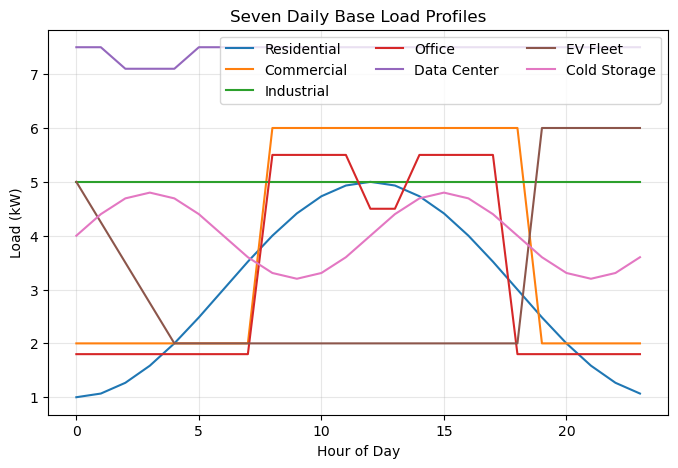

In [138]:
n_customers = 500
hours = np.arange(24)

# Seven daily base load profiles (kW) for different customer segments
# 1. Residential: Morning + evening peaks
residential = (np.sin((hours-6)/24*2*np.pi) * 2 + 3)
# 2. Commercial (retail/office): Business hours plateau
commercial = np.where((hours>=8) & (hours<=18), 6, 2)
# 3. Industrial (steady process)
industrial = np.full(24, 5)
# 4. Office with sharper lunch dip
office = np.where((hours>=8) & (hours<=17), 5.5, 1.8)
office[12:14] -= 1.0  # lunch dip
# 5. Data center (very flat, slight night cooling dip)
data_center = np.full(24, 7.5)
data_center[2:5] -= 0.4
# 6. EV fleet charging (evening/night dominant)
ev_fleet = np.ones(24)*2
ev_fleet[19:24] = 6
_ev_night = np.linspace(5, 2, 5)
ev_fleet[0:5] = _ev_night
# 7. Cold storage / refrigeration (baseline + compressor cycles)
cold_storage = np.full(24, 4.0)
cycle = (np.sin((hours)/24*4*np.pi) * 0.8)
cold_storage += cycle

plt.figure(figsize=(8, 5))
plt.plot(hours, residential, label='Residential')
plt.plot(hours, commercial, label='Commercial')
plt.plot(hours, industrial, label='Industrial')
plt.plot(hours, office, label='Office')
plt.plot(hours, data_center, label='Data Center')
plt.plot(hours, ev_fleet, label='EV Fleet')
plt.plot(hours, cold_storage, label='Cold Storage')
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('Seven Daily Base Load Profiles')
plt.legend(ncol=3)
plt.grid(True, alpha=0.3)
plt.show()

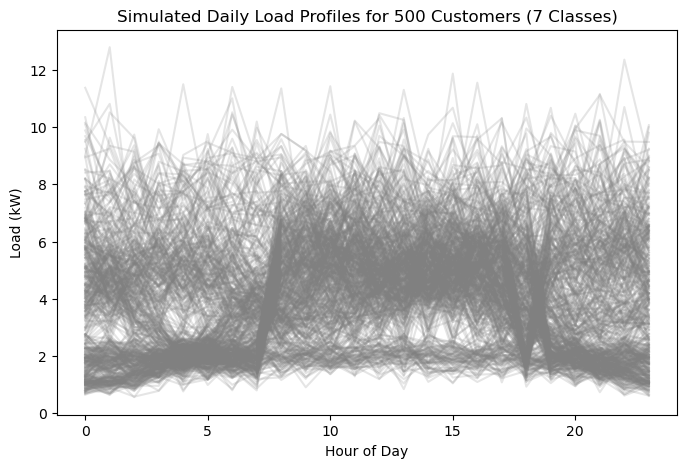

Class distribution:
Cold Storage: 75
Commercial  : 75
Data Center : 56
EV Fleet    : 71
Industrial  : 72
Office      : 67
Residential : 84


In [139]:
np.random.seed(42)
profiles = []
# Expanded base profiles list (7 classes)
base_profiles = [
    residential,
    commercial,
    industrial,
    office,
    data_center,
    ev_fleet,
    cold_storage
]
base_labels = ['Residential','Commercial','Industrial','Office','Data Center','EV Fleet','Cold Storage']
assigned_labels = []

for i in range(n_customers):
    idx = np.random.randint(0, len(base_profiles))
    base = base_profiles[idx]
    assigned_labels.append(base_labels[idx])
    # Multiplicative noise: scale base by random factor around 1
    noise = np.random.normal(1.0, 0.2, 24)
    profile = base * noise
    profiles.append(profile)

profiles = np.array(profiles)

plt.figure(figsize=(8, 5))
for profile in profiles:
    plt.plot(hours, profile, color='gray', alpha=0.2)
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('Simulated Daily Load Profiles for 500 Customers (7 Classes)')
plt.show()

# Quick class distribution check
(unique, counts) = np.unique(assigned_labels, return_counts=True)
print('Class distribution:')
for u, c in zip(unique, counts):
    print(f'{u:12s}: {c}')

#### Task
Perform k-means clustering on `profiles` and visualize its cluster centers versus the base profiles. How can you quantify the performance of your clustering?

Discuss when and how the data should be preprocessed.

In [140]:
# Your implementation here

### Part 2 - Solar Forecasting Support (Agglomerative Clustering + Regression)
---

Here we generate weather data (temperature, humidity, wind, cloud cover) and corresponding solar production.

Then we use **Agglomerative Clustering** to group weather conditions into categories (e.g., sunny, cloudy, mixed).

Then we add the cluster labels as extra features to a regression model predicting solar output.

The comparison of forecast errors with and without clustering shows how unsupervised learning can enhance forecasting accuracy by capturing hidden regimes in the data.

#### Data generation 
We simulate weather data and PV Output for 40 days

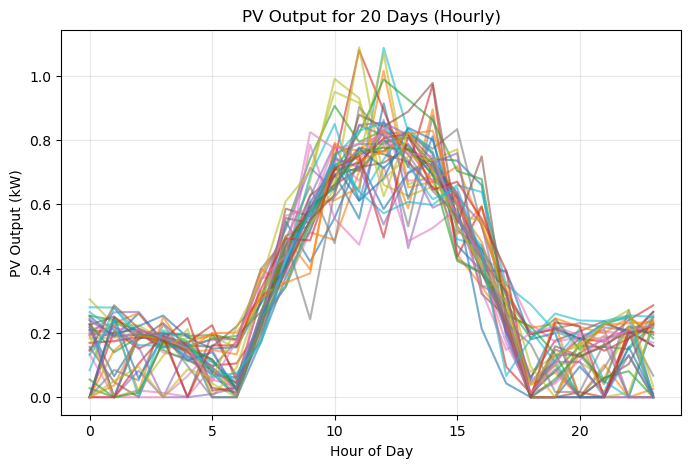

In [141]:
np.random.seed(42)

# Parameters
n_days = 40
n_samples = n_days * 24  # 40 days hourly
lat = 47 * np.pi / 180  # radians
hours = np.arange(n_samples)
days = hours // 24
local_hour = hours % 24

# --- 1. Solar geometry: clear-sky irradiance ---
# Simple model: solar altitude ~ sin(pi * (hour-6)/12) scaled
solar_altitude = np.clip(np.sin(np.pi * (local_hour - 6) / 12), 0, None)
I_clear = 1.0 * solar_altitude  # normalized irradiance (kW/m²)

# --- 2. Regimes with persistence (Markov chain) ---
regimes = ["Clear", "Partly", "Overcast"]
transition_matrix = np.array([
    [0.85, 0.10, 0.05],
    [0.15, 0.70, 0.15],
    [0.05, 0.15, 0.80],
])

state = 0
regime_seq = []
for _ in range(n_samples):
    regime_seq.append(regimes[state])
    state = np.random.choice([0, 1, 2], p=transition_matrix[state])

# --- 3. Cloud cover distributions ---
cloud_cover = []
for r in regime_seq:
    if r == "Clear":
        cc = np.random.beta(2, 8)
    elif r == "Partly":
        cc = np.random.beta(4, 4)
    else:  # Overcast
        cc = np.random.beta(8, 2)
    cloud_cover.append(cc)
cloud_cover = np.array(cloud_cover)

# --- 4. Temperature ---
# Base diurnal sinusoid: 10°C amplitude around 15°C mean
T_base = 15 + 10 * np.sin(2 * np.pi * (local_hour - 6) / 24)
regime_offset = {"Clear": +3, "Partly": 0, "Overcast": -3}
T = np.array([T_base[i] + regime_offset[regime_seq[i]] + np.random.normal(0, 1)
              for i in range(n_samples)])

# --- 5. Humidity ---
H = 0.7 + 0.2 * cloud_cover - 0.01 * (T - 20) + np.random.normal(0, 0.05, n_samples)
H = np.clip(H, 0, 1)

# --- 6. Wind speed ---
W = []
for i, r in enumerate(regime_seq):
    base = 2 if r == "Clear" else (3 if r == "Partly" else 4)
    diurnal = 1 + 0.5 * np.sin(2 * np.pi * (local_hour[i] - 12) / 24)
    w = np.random.normal(base + diurnal, 0.5)
    W.append(max(w, 0))
W = np.array(W)

# --- 7. Solar output (PV generation) ---
# Attenuation by clouds
attenuation = 1 - 0.75 * cloud_cover**3
I_effective = I_clear * attenuation

T_module = T + 5  # module runs hotter than air
eta_T = 1 - 0.005 * (T_module - 25)
PV_base = I_effective * np.clip(eta_T, 0, None)

# Regime-specific adjustments to creat heterogenoues linear patterns
PV_output = []
for i, r in enumerate(regime_seq):
    pv = PV_base[i]
    if r == "Clear":
        # Strong negative dependence on termperature
        pv += -0.02 * (T[i] - 20)
    elif r == "Overcast":
        # Small positive depende on wind (mixing, cooling)
        pv += 0.03 * W[i]
        # More humidity -> slightly higher diffuse contribution
        pv += 0.05 * H[i]
    elif r == "Partly":
        # Add high variance (cloud transients)
        pv += np.random.normal(0, 0.1)
    pv += np.random.normal(0, 0.02) # general noise
    PV_output.append(max(pv,0))
PV_output = np.array(PV_output)

# Plot PV output of all 20 days
plt.figure(figsize=(8, 5))
for d in range(n_days):
    plt.plot(local_hour[d*24:(d+1)*24], PV_output[d*24:(d+1)*24], alpha=0.6)
plt.xlabel('Hour of Day')
plt.ylabel('PV Output (kW)')
plt.title('PV Output for 20 Days (Hourly)')
plt.grid(True, alpha=0.3)
plt.show()

#### Task:
Use **Agglomerative Clustering** before performing a regression where `PV_output`is your target and `weather` contains your features. Add the cluster labels as additional feature and see if it improves the performance of the regression model. How many clusters yield the best performance?

*Optional:* Make a separate regression for each cluster and see if it improves performance.

In [142]:
# Collect weather features in DataFrame
weather = pd.DataFrame({
    "cloud_cover": cloud_cover,
    "temperature": T,
    "humidity": H,
    "wind_speed": W,
})

# Your implementation here

### Part 3 - Market & Price Pattern Discovery (K-Means)
---

We simulate daily electricity price curves with different hidden regimes (flat prices, evening peak, solar midday dip).

Using **K-Means clustering**, we discover these regimes automatically, without prior labels.

This mimics how clustering can help market operators and traders identify price patterns, system stress conditions, or renewable penetration effects, which supports market analysis and risk management.

#### Data generation 
We simulate price data for 300 days from three distinct regimes.

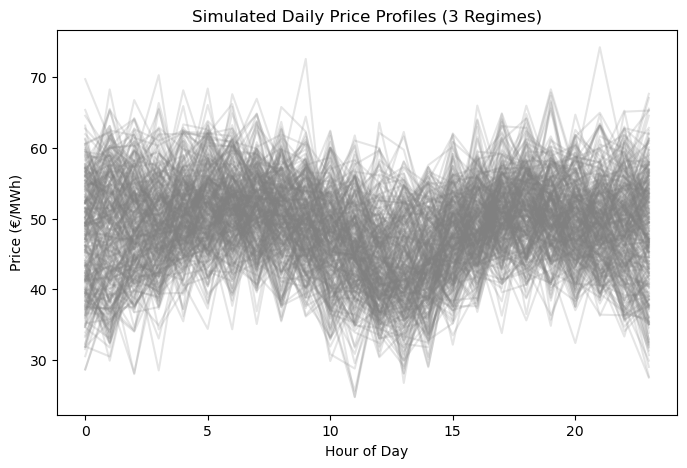

In [143]:
np.random.seed(42)
n_days = 300
hours = np.arange(24)

price_profiles = []
true_labels = []

for i in range(n_days):
    regime = np.random.choice([0, 1, 2])  # flat, evening peak, midday dip
    true_labels.append(regime)

    if regime == 0:
        # Flat profile
        base = np.full(24, 50) + np.random.normal(0, 5, 24)
    elif regime == 1:
        # Evening peak (hour 18–22)
        base = 40 + 10*np.sin((hours-12)/12*np.pi)**2
        base += np.random.normal(0, 5, 24)
    else:
        # Midday dip (solar effect around hour 12–15)
        base = 55 - 15*np.exp(-0.5*((hours-13)/2)**2)
        base += np.random.normal(0, 5, 24)

    price_profiles.append(base)

price_profiles = np.array(price_profiles)
true_labels = np.array(true_labels)

# Plot prices for all days
plt.figure(figsize=(8, 5))
for profile in price_profiles:
    plt.plot(hours, profile, color='gray', alpha=0.2)
plt.xlabel('Hour of Day')
plt.ylabel('Price (€/MWh)')
plt.title('Simulated Daily Price Profiles (3 Regimes)')
plt.show()

#### Task
As in Part 1, perform k-means clustering on `price_profiles`, visualize its cluster centers and quantify the performance.

How would you preprocess the data this time?

In [144]:
# Your implementation here
